In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
MODEL_NAME = 'LSTM'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = LSTM, DEVICE = cpu


# Generate data

This is a toy example to predict a sequence with RNN.
In this example, Y is a sequence of 2D vectors (sin(x), cos(x)) for x in [-3.14, +3.14]

In practical applications, replace Y with the sequence to predict

In [0]:
# range of the data
X = np.linspace(-3.14 * 2, 3.14 * 2, 100)

In [4]:
#Y = np.array([(np.sin(x), np.cos(x)) for x in X])
Y = np.array([(np.sin(x) + np.random.normal(0, 0.1), np.cos(x) + np.random.normal(0, 0.1)) for x in X])
Y[:10]

array([[-0.06151831,  1.03419596],
       [ 0.12157721,  0.91866545],
       [ 0.2985502 ,  0.96814955],
       [ 0.31021222,  1.11465363],
       [ 0.3800882 ,  0.92145779],
       [ 0.7721839 ,  0.84980167],
       [ 0.66035121,  0.72591441],
       [ 0.76197562,  0.63828647],
       [ 0.99344568,  0.50165601],
       [ 0.93084459,  0.53050892]])

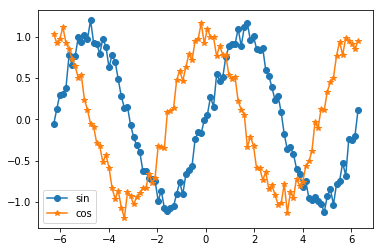

In [5]:
plt.plot(X, Y[:,0], label="sin", marker="o")
plt.plot(X, Y[:,1], label="cos", marker='*')
plt.legend()

## Convert numpy array to torch.Tensor

In [6]:
# convert Y into input tensors
input_tensor = torch.tensor(Y, dtype=torch.float32).to(DEVICE)
#input_tensor = torch.tensor(Y, dtype=torch.float32)
input_tensor.shape

torch.Size([100, 2])

In [7]:
# check input_tensor
input_tensor[:10]

tensor([[-0.0615,  1.0342],
        [ 0.1216,  0.9187],
        [ 0.2986,  0.9681],
        [ 0.3102,  1.1147],
        [ 0.3801,  0.9215],
        [ 0.7722,  0.8498],
        [ 0.6604,  0.7259],
        [ 0.7620,  0.6383],
        [ 0.9934,  0.5017],
        [ 0.9308,  0.5305]])

In [8]:
# make target_tensor by rotating input_tensor
target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0).to(DEVICE)
#target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0)
target_tensor[:10]

tensor([[0.1216, 0.9187],
        [0.2986, 0.9681],
        [0.3102, 1.1147],
        [0.3801, 0.9215],
        [0.7722, 0.8498],
        [0.6604, 0.7259],
        [0.7620, 0.6383],
        [0.9934, 0.5017],
        [0.9308, 0.5305],
        [1.0233, 0.2390]])

In [9]:
# check the input and target tensors
print(torch.cat((input_tensor, target_tensor), 1)[:10])

tensor([[-0.0615,  1.0342,  0.1216,  0.9187],
        [ 0.1216,  0.9187,  0.2986,  0.9681],
        [ 0.2986,  0.9681,  0.3102,  1.1147],
        [ 0.3102,  1.1147,  0.3801,  0.9215],
        [ 0.3801,  0.9215,  0.7722,  0.8498],
        [ 0.7722,  0.8498,  0.6604,  0.7259],
        [ 0.6604,  0.7259,  0.7620,  0.6383],
        [ 0.7620,  0.6383,  0.9934,  0.5017],
        [ 0.9934,  0.5017,  0.9308,  0.5305],
        [ 0.9308,  0.5305,  1.0233,  0.2390]])


# Create LSTM Class

In [0]:
import torch
import torch.nn as nn


# RNN to predict the sequence

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_size).to(DEVICE)
        self.h2o = nn.Linear(hidden_size, output_size).to(DEVICE)

    def forward(self, input, hidden):
#        print("input = {}".format(input))
#        print("hidden = {}".format(hidden))
#        print("reshaped = {}".format(input.view(1,1,-1)))         
        output, hidden = self.lstm(input.view(len(input),1,-1), hidden)
    
        h, c = hidden
        output = self.h2o(h)
        
        return output, hidden

    def initHidden(self):
#       return torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)      
        return torch.zeros(1, 1, self.hidden_size).to(DEVICE), torch.zeros(1, 1, self.hidden_size).to(DEVICE)
      

In [0]:
rnn = RNN(2, 32, 2)

# Train RNN

In [0]:
# utility function to measure time
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def get_data(X):
#    X = np.linspace(-3.14 * 2, 3.14 * 2, 100)
    Y = np.array([(np.sin(x) + np.random.normal(0, 0.1), np.cos(x) + np.random.normal(0, 0.1)) for x in X])
    input_tensor = torch.tensor(Y, dtype=torch.float32).to(DEVICE)
#   input_tensor = torch.tensor(Y, dtype=torch.float32)
  
    target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0).to(DEVICE)
    #target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0)
    
    return input_tensor, target_tensor

In [0]:
# select loss function
criterion = nn.MSELoss()

# learning rate
learning_rate = 0.0005

# set optimilzer
optimizer = torch.optim.Adam(rnn.parameters(), lr = learning_rate)

In [0]:
# define train function that trains for one step
def train(input_tensor, target_tensor):
    hidden = rnn.initHidden()

#    print("hidden = {}".format(hidden))
  
    rnn.zero_grad()

    loss = 0

    for i in range(input_tensor.size(0)):
#        print("Input = {}, hidden = {}".format(input_tensor[i], hidden))
        output, hidden = rnn(input_tensor[i:i+1], hidden)
#        print("output = {}, target = {}".format(output, target_tensor[i:i+1]))
    
        l = criterion(output, target_tensor[i:i+1])
        loss += l
        
    loss.backward()
    optimizer.step()

    return output, loss.item() / input_tensor.size(0)

### Note that pytorch modules inputs a batch rather than a vector!

In [16]:
# input_tensor[0].shape = torch.Size([2])
print("input_tensor[0] = {}, shape = {}".format(input_tensor[0], input_tensor[0].shape))

# input_tensor[0:1].shape = torch.Size([1, 2])
print("input_tensor[0:1] = {}, shape = {}".format(input_tensor[0:1], input_tensor[0:1].shape))

input_tensor[0] = tensor([-0.0615,  1.0342]), shape = torch.Size([2])
input_tensor[0:1] = tensor([[-0.0615,  1.0342]]), shape = torch.Size([1, 2])


In [0]:
# reset loss history
all_losses = []

In [18]:
n_iters = 5000
print_every = 200
plot_every = 200

total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    input_tensor, target_tensor = get_data(X)
    
    output, loss = train(input_tensor, target_tensor)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 8s (200 4%) 0.0184
0m 16s (400 8%) 0.0158
0m 24s (600 12%) 0.0138
0m 32s (800 16%) 0.0122
0m 40s (1000 20%) 0.0119
0m 48s (1200 24%) 0.0109
0m 57s (1400 28%) 0.0109
1m 5s (1600 32%) 0.0098
1m 13s (1800 36%) 0.0111
1m 21s (2000 40%) 0.0100
1m 30s (2200 44%) 0.0108
1m 38s (2400 48%) 0.0095
1m 46s (2600 52%) 0.0088
1m 54s (2800 56%) 0.0105
2m 2s (3000 60%) 0.0114
2m 11s (3200 64%) 0.0107
2m 19s (3400 68%) 0.0121
2m 27s (3600 72%) 0.0115
2m 35s (3800 76%) 0.0106
2m 44s (4000 80%) 0.0105
2m 51s (4200 84%) 0.0095
2m 59s (4400 88%) 0.0095
3m 7s (4600 92%) 0.0111
3m 16s (4800 96%) 0.0109
3m 24s (5000 100%) 0.0110


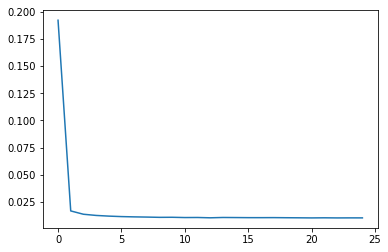

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [20]:
predict_tensor = torch.tensor([[np.sin(X[0]), np.cos(X[0])]]).to(DEVICE)
predict_tensor

tensor([[0.0032, 1.0000]])

In [0]:
hidden = rnn.initHidden();

for i in range(1,len(X)):
#  print("input = {}".format(predict[-1:]))
#  print("hidden = {}".format(hidden))
  output, hidden = rnn(predict_tensor[-1:], hidden)
  
#  print("output = {}".format(output[0]))
  
  predict_tensor = torch.cat((predict_tensor, output[0]), 0)
#  print("predict = {}".format(predict))

In [22]:
print("predict.shape = {}".format(predict_tensor.shape))
predict_tensor[:10]

predict.shape = torch.Size([100, 2])


tensor([[0.0032, 1.0000],
        [0.1476, 0.9387],
        [0.2487, 0.9819],
        [0.3701, 0.9461],
        [0.4877, 0.8834],
        [0.5948, 0.8073],
        [0.6907, 0.7207],
        [0.7755, 0.6252],
        [0.8488, 0.5221],
        [0.9096, 0.4118]], grad_fn=<SliceBackward>)

predict[:,0].shape = (100,)
predict[:,1].shape = (100,)


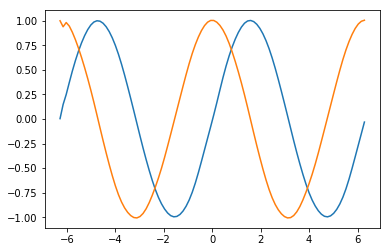

In [24]:
predict = predict_tensor.cpu().detach().numpy()

print("predict[:,0].shape = {}".format(predict[:,0].shape))
print("predict[:,1].shape = {}".format(predict[:,1].shape))

plt.plot (X, predict[:,0])
plt.plot (X, predict[:,1])